In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import string
import re

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS as sklear_stopwords
# from spacytextblob.spacytextblob import SpacyTextBlob
# from nrclex import NRCLex

sns.set_style('whitegrid');
sns.set_context('notebook', font_scale=1.1);
# nltk.download('stopwords')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
root = '/content/drive/My Drive/surely_not_sarcasm_data/'

# load the data

In [6]:
names = pd.read_csv(root+'data/key.csv', sep='\t').columns.tolist()

In [7]:
df = pd.read_csv(root+'data/train-balanced.csv', sep='\t', header=None, names=names)
df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,1476662123,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,1477959850,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,1474580737,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,1476824627,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,1483117213,Yep can confirm I saw the tool they use for th...


In [8]:
df.shape

(1010826, 10)

In [9]:
df.drop(['author', 'subreddit', 'score', 'ups', 'downs', 'date', 'created_utc'], axis=1, inplace=True)
df.dropna(inplace=True)

In [10]:
df.head()

,label,comment,parent_comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...


In [11]:
df['comment'] = (df['comment']
         .str.replace(r'&amp;nbsp;', ' ', regex=False)
         .str.replace(r'&amp;', '&', regex=False)
         .str.replace(r'&lt;', '<', regex=False)
         .str.replace(r'&gt;', '>', regex=False)
         .str.replace(r'&quot;', '"', regex=False)
)

df['parent_comment'] = (df['parent_comment']
         .str.replace(r'&amp;nbsp;', ' ', regex=False)
         .str.replace(r'&amp;', '&', regex=False)
         .str.replace(r'&lt;', '<', regex=False)
         .str.replace(r'&gt;', '>', regex=False)
         .str.replace(r'&quot;', '"', regex=False)
)

In [12]:
df.to_csv(root+'data/train_balanced_smaller.csv', index=False)

In [13]:
df['label'].value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [215]:
df.shape[0], df['parent_comment'].nunique()

(1010773, 984238)

In [216]:
df['parent_comment'].value_counts()[:5]

me irl    257
Why?      232
No.       140
Cat.      134
Yes.      121
Name: parent_comment, dtype: int64

In [217]:
df[df['parent_comment'] == "Screw the Disabled--I've got to get to Church on Time"]

,label,comment,parent_comment
1010823,1,Perhaps this is an atheist conspiracy to make ...,Screw the Disabled--I've got to get to Church ...


In [ ]:
# "Screw the Disabled--I've got to get to Church on Time" the fuck xd

# words, bigrams, trigrams...

In [14]:
def cleaner_df(df):
    df_cleaner = (df
         .str.replace(r'http\S+', '', regex=True)
         .str.replace(r'\bu/\S+', '', regex=True)
    )
    return df_cleaner

In [15]:
def plot_word_counts(comments, n=1, orientation='v'):
    which = {1: 'words', 2: 'bigrams', 3: 'trigrams'}
    
    all_sw = list(sklear_stopwords) + stopwords.words('english')
    count_vectorizer = CountVectorizer(stop_words=all_sw, max_features=20, ngram_range=(n,n))
    fit = count_vectorizer.fit_transform(cleaner_df(comments))

    counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit.sum(axis=0).tolist()[0]})
    counts = counts.sort_values(by=['count'], ascending=False, ignore_index=True)
    
    if orientation == 'h':
        figsize, rot = (8,8), 0
        x, y = counts['count'], counts['word']
    else:
        figsize, rot = (14,6), 45
        x, y = counts['word'], counts['count']
        
    plt.figure(figsize=figsize)
    sns.barplot(x=x, y=y, palette='flare_r');
    plt.title(fr'20 most common {which[n]} in sarcastic comments', fontsize=19)
    plt.xticks(rotation=rot);

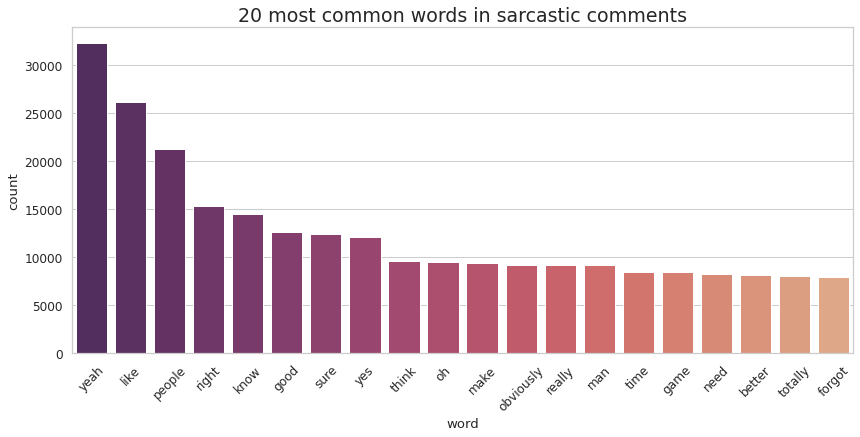

In [221]:
plot_word_counts(df['comment'][df['label'] == 1], n=1)

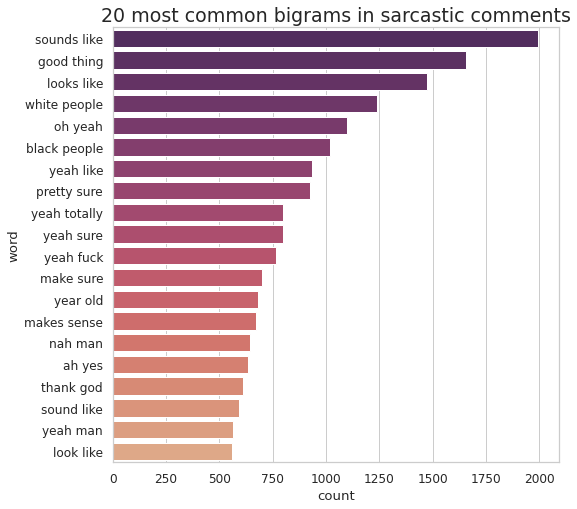

In [29]:
plot_word_counts(df['comment'][df['label'] == 1], n=2, orientation='h')

In [ ]:
# some sample tweets with mentioned bigrams

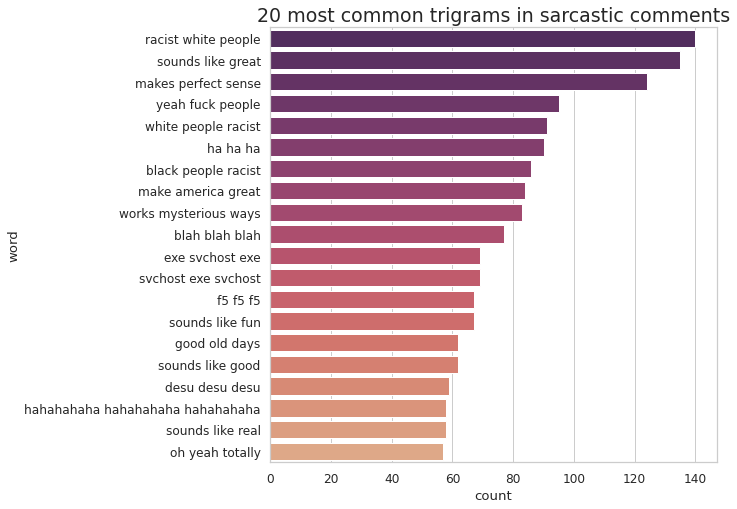

In [30]:
plot_word_counts(df['comment'][df['label'] == 1], n=3, orientation='h')

In [ ]:
# what are these amp, nbsp, f5, desu...?

- amp, nbsp are html entities
- Kawaii desu means “it's cute” in Japanese.

# pyramid plots

In [40]:
def compare_counts(n=1):
    all_sw = list(sklear_stopwords) + stopwords.words('english')
    count_vectorizer = CountVectorizer(stop_words=all_sw, ngram_range=(n,n))

    fit = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 1]))
    counts_sarc = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                                'count_sarc':fit.sum(axis=0).tolist()[0]})

    fit = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 0]))
    counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                           'count':fit.sum(axis=0).tolist()[0]})
    
    df_diff = pd.merge(counts_sarc, counts, how='outer', on='word').fillna(0)
    df_diff['diff'] = (df_diff['count_sarc']-df_diff['count']).abs()
    df_diff = df_diff.sort_values(by='diff', ascending=False, ignore_index=True).head(25)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

    sns.barplot(data=df_diff, x='count_sarc', y='word', ax=ax1, palette='flare_r')
    ax1.invert_xaxis()
    ax1.set(yticklabels=[])
    ax1.set_ylabel('')

    sns.barplot(data=df_diff, x='count', y='word', ax=ax2, palette='flare_r');
    ax2.set_ylabel('');
    # ax2.set(yticklabels=[label.get_text().center(10) for label in ax2.get_yticklabels()]);

    ax2.set(yticklabels=[])
    for yloc, word in zip(np.arange(df_diff.shape[0]), df_diff.word):
        ax2.annotate(word, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')
        
    fig.subplots_adjust(wspace=0.45)

    plt.tight_layout()

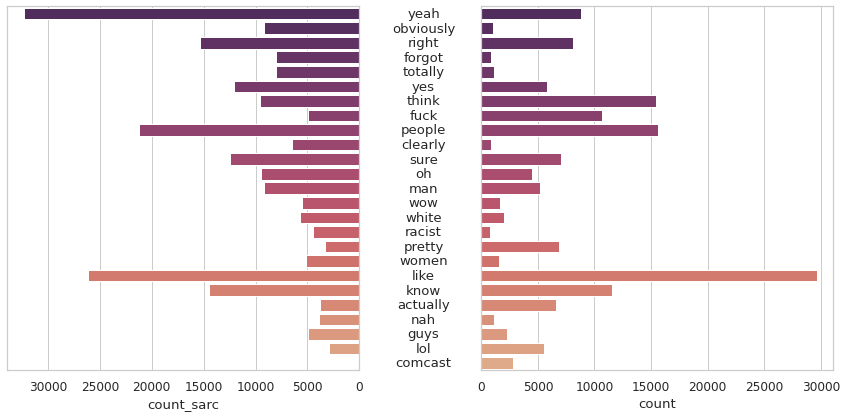

In [41]:
compare_counts(n=1)

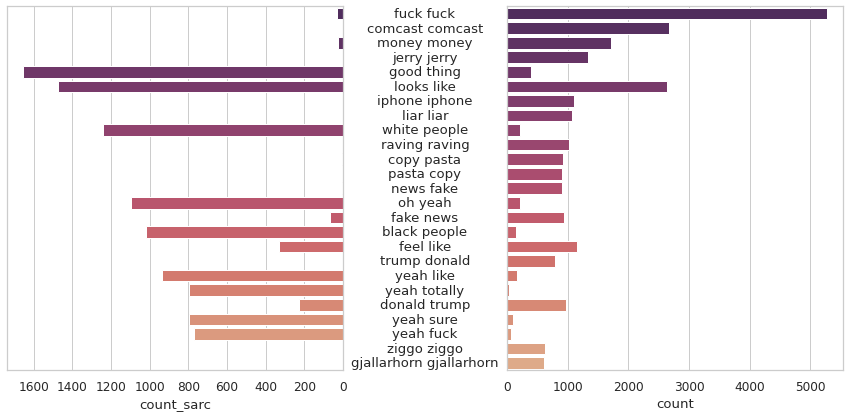

In [42]:
compare_counts(n=2)

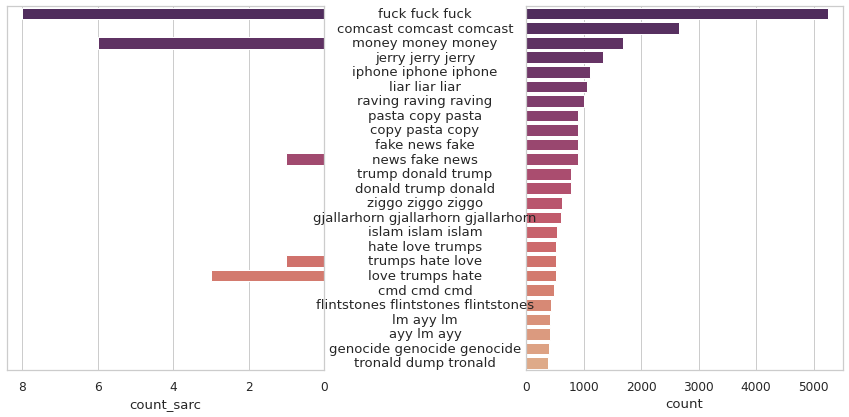

In [43]:
compare_counts(n=3)

In [ ]:
# some differences are big, because the magnitude is big, maybe do something about that
# maybe take words that appear more than x times in the corpus and then divide each count by the totl number of times
# the word appeared in the corpus and calculate the difference based on that

# also do something with individual words turning into bigrams/trigrams

# punctuation

In [224]:
count_vectorizer = CountVectorizer(token_pattern=r'[^a-zA-Z\d\s]', max_features=20)#r'[.,!?:;\'\"\\\-\]\[()/]')

fit_sarcasm = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 1]))
counts_sarcasm = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit_sarcasm.sum(axis=0).tolist()[0]})
counts_sarcasm = counts_sarcasm.sort_values(by=['count'], ascending=False).reset_index(drop=True)

fit = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 0]))
counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

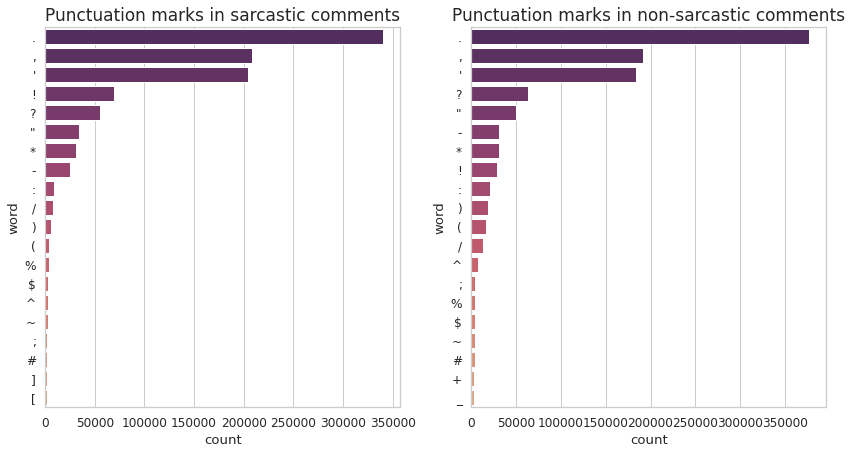

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

sns.barplot(y=counts_sarcasm['word'], x=counts_sarcasm['count'], palette='flare_r', ax=ax1);
ax1.set_title('Punctuation marks in sarcastic comments', fontsize=17);

sns.barplot(y=counts['word'], x=counts['count'], palette='flare_r', ax=ax2);
ax2.set_title('Punctuation marks in non-sarcastic comments', fontsize=17);

in sarcastic comments exclamation mark is used much more often

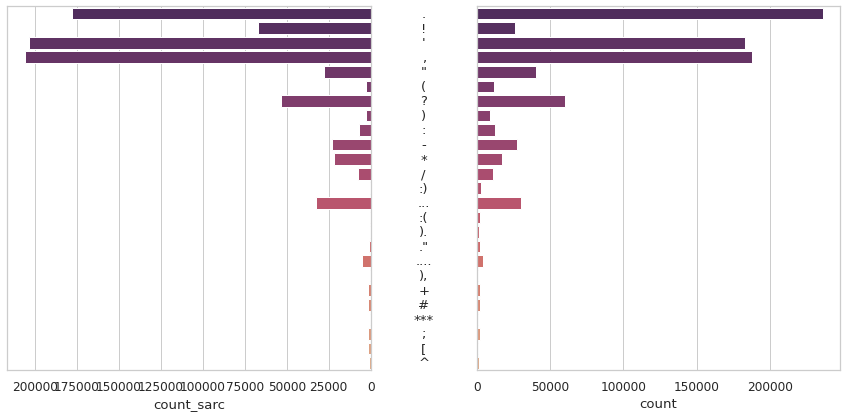

In [21]:
count_vectorizer = CountVectorizer(token_pattern=r'[^a-zA-Z\d\s]+')#r'[.,!?:;\'\"\\\-\]\[()/]')

fit_sarc = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 1]))
counts_sarc = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                            'count_sarc':fit_sarc.sum(axis=0).tolist()[0]})

fit = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 0]))
counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                       'count':fit.sum(axis=0).tolist()[0]})

df_diff = pd.merge(counts_sarc, counts, how='outer', on='word').fillna(0)
df_diff['diff'] = (df_diff['count_sarc']-df_diff['count']).abs()
df_diff = df_diff.sort_values(by='diff', ascending=False, ignore_index=True).head(25)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

sns.barplot(data=df_diff, x='count_sarc', y='word', ax=ax1, palette='flare_r')
ax1.invert_xaxis()
ax1.set(yticklabels=[])
ax1.set_ylabel('')

sns.barplot(data=df_diff, x='count', y='word', ax=ax2, palette='flare_r');
ax2.set_ylabel('');

ax2.set(yticklabels=[])
for yloc, word in zip(np.arange(df_diff.shape[0]), df_diff.word):
    ax2.annotate(word, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')

fig.subplots_adjust(wspace=0.5)
plt.tight_layout()

In [28]:
count_vectorizer = CountVectorizer(token_pattern=r'[^a-zA-Z\d\s]')#r'[.,!?:;\'\"\\\-\]\[()/]')

fit_sarc = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 1]))
counts_sarc = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                            'count_sarc':fit_sarc.sum(axis=0).tolist()[0]})

fit = count_vectorizer.fit_transform(cleaner_df(df['comment'][df['label'] == 0]))
counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(),
                       'count':fit.sum(axis=0).tolist()[0]})

df_diff = pd.merge(counts_sarc, counts, how='outer', on='word').fillna(0)
df_diff['diff'] = (df_diff['count_sarc']-df_diff['count']).abs()
df_diff = df_diff.sort_values(by='diff', ascending=False, ignore_index=True)#.head(25)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))

# sns.barplot(data=df_diff, x='count_sarc', y='word', ax=ax1, palette='flare_r')
# ax1.invert_xaxis()
# ax1.set(yticklabels=[])
# ax1.set_ylabel('')

# sns.barplot(data=df_diff, x='count', y='word', ax=ax2, palette='flare_r');
# ax2.set_ylabel('');

# ax2.set(yticklabels=[])
# for yloc, word in zip(np.arange(df_diff.shape[0]), df_diff.word):
#     ax2.annotate(word, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')

# fig.subplots_adjust(wspace=0.5)
# plt.tight_layout()

In [52]:
df['comment'][df['comment'].str.contains(':D', regex=False)]

233        For those wondering, those are not my pictures...
1239       it's not 100% taxable, but they will check if ...
1644       Yeap,i've faced red dead head before... Say hi...
2133                    Also 105 and started pre season 6 :D
4243       This is fucking awesome, best thing i've seen ...
                                 ...                        
1004229    I love the fact that the AI types "gg" before ...
1007144                              High levels of crime :D
1008443    I'm sure he can cover himself and any family m...
1008623    :D I'm proud to hear that you're reading my bl...
1009104                   Whoa, you must be fun at movies :D
Name: comment, Length: 1520, dtype: object

In [29]:
df_diff['perc_sarc'] = df_diff['count_sarc']/ (df_diff['count_sarc']+df_diff['count'])
df_diff['perc'] = df_diff['count']/ (df_diff['count_sarc']+df_diff['count'])
df_diff['perc_diff'] = (df_diff['perc_sarc']-df_diff['perc']).abs()
df_diff

,word,count_sarc,count,diff,perc_sarc,perc,perc_diff
0,!,69537,28146.0,41391.0,0.711864,0.288136,0.423728
1,.,340677,377446.0,36769.0,0.474399,0.525601,0.051202
2,',204447,184283.0,20164.0,0.525936,0.474064,0.051871
3,",",208304,191206.0,17098.0,0.521399,0.478601,0.042797
4,"""",33813,50097.0,16284.0,0.402967,0.597033,0.194065
5,),5416,18562.0,13146.0,0.225874,0.774126,0.548253
6,(,4289,15941.0,11652.0,0.212012,0.787988,0.575976
7,:,8825,20411.0,11586.0,0.301854,0.698146,0.396292
8,?,55110,62958.0,7848.0,0.466765,0.533235,0.066470
9,-,24847,30966.0,6119.0,0.445183,0.554817,0.109634


# comment length

In [ ]:
df['length'] = df['comment'].str.len()
df['word count'] = df['comment'].str.split().str.len()

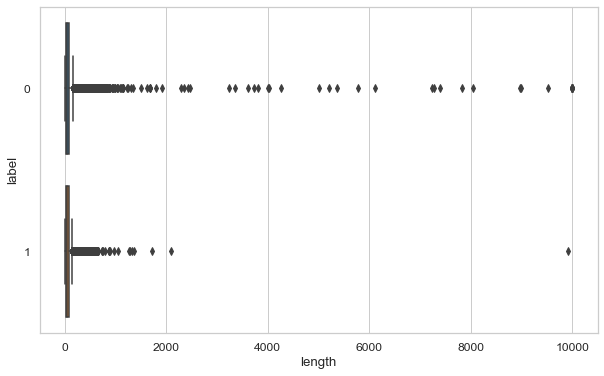

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='length', y='label', orient='h');

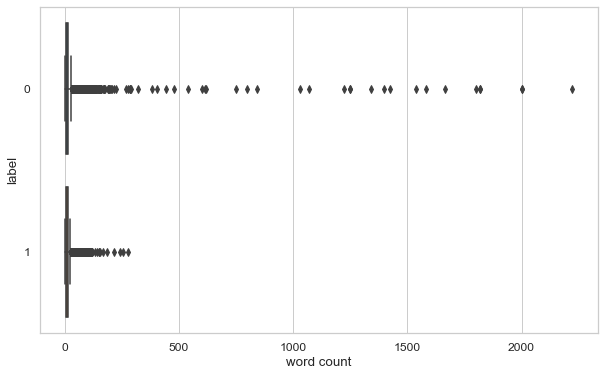

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='word count', y='label', orient='h');

In [ ]:
df['comment'].str.len().groupby(df['label']).mean()

label
0    56.934769
1    56.449811
Name: comment, dtype: float64

In [ ]:
df['comment'].str.split().str.len().groupby(df['label']).mean()

label
0    10.591973
1    10.330915
Name: comment, dtype: float64

# parent comments for sarcasm

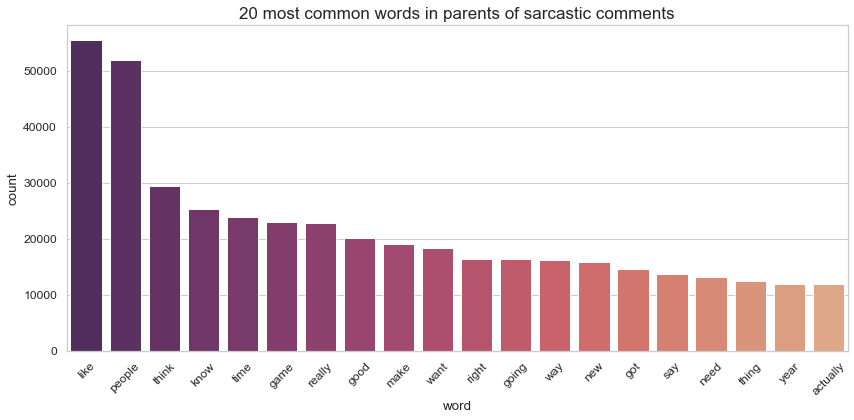

In [ ]:
all_sw = list(sklear_stopwords) + stopwords.words('english')
count_vectorizer = CountVectorizer(stop_words=all_sw, max_features=20)
fit = count_vectorizer.fit_transform(df['parent_comment'][df['label'] == 1])

counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(14,6))
sns.barplot(x=counts['word'], y=counts['count'], palette='flare_r');
plt.title('20 most common words in parents of sarcastic comments', fontsize=17)
plt.xticks(rotation=45);

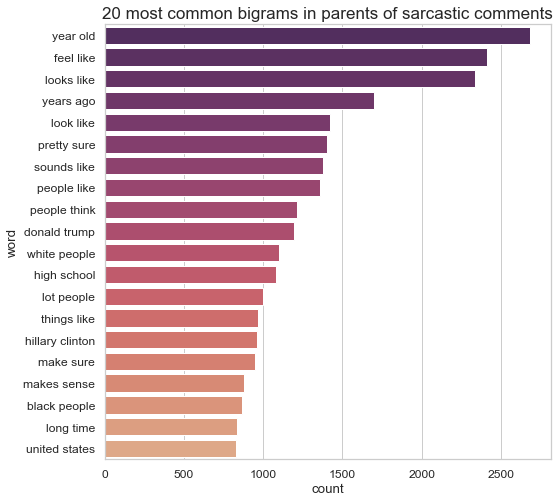

In [ ]:
count_vectorizer = CountVectorizer(stop_words=all_sw, max_features=20, ngram_range=(2,2))
fit = count_vectorizer.fit_transform(df['parent_comment'][df['label'] == 1])

counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

plt.figure(figsize=(8,8))
sns.barplot(y=counts['word'], x=counts['count'], palette='flare_r');
plt.title('20 most common bigrams in parents of sarcastic comments', fontsize=17);

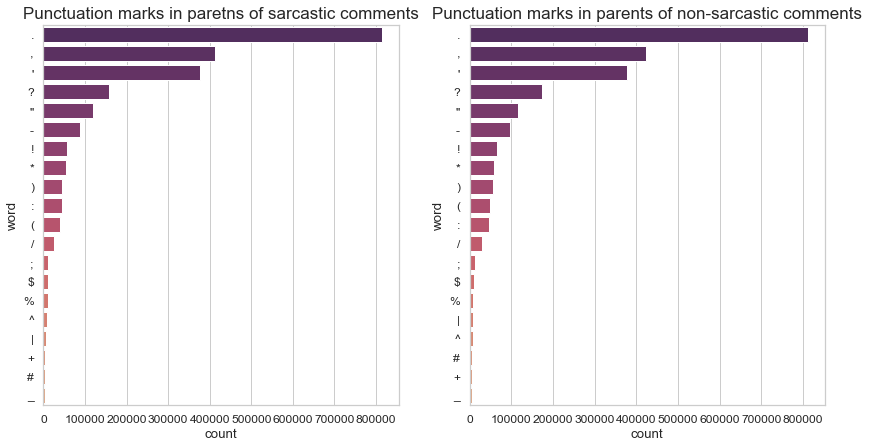

In [ ]:
count_vectorizer = CountVectorizer(token_pattern=r'[^a-zA-Z\d\s]', max_features=20)#r'[.,!?:;\'\"\\\-\]\[()/]')

fit_sarcasm = count_vectorizer.fit_transform(df['parent_comment'][df['label'] == 1])
counts_sarcasm = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit_sarcasm.sum(axis=0).tolist()[0]})
counts_sarcasm = counts_sarcasm.sort_values(by=['count'], ascending=False).reset_index(drop=True)

fit = count_vectorizer.fit_transform(df['parent_comment'][df['label'] == 0])
counts = pd.DataFrame({'word':count_vectorizer.get_feature_names_out(), 'count':fit.sum(axis=0).tolist()[0]})
counts = counts.sort_values(by=['count'], ascending=False).reset_index(drop=True)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,7))

sns.barplot(y=counts_sarcasm['word'], x=counts_sarcasm['count'], palette='flare_r', ax=ax1);
ax1.set_title('Punctuation marks in paretns of sarcastic comments', fontsize=17);

sns.barplot(y=counts['word'], x=counts['count'], palette='flare_r', ax=ax2);
ax2.set_title('Punctuation marks in parents of non-sarcastic comments', fontsize=17);

like no difference really

# sentiment

In [ ]:
nlp = spacy.load('en_core_web_sm')
nlp.add_pipe('spacytextblob')
sia = SentimentIntensityAnalyzer()

def sentiment_analysis(comment):
    doc = nlp(comment)
    vader_polarity = sia.polarity_scores(comment)['compound']
    return doc._.polarity, doc._.subjectivity, vader_polarity

sentiment = df['comment'].map(sentiment_analysis).tolist()
df['polarity'], df['subjectivity'], df['vader polarity'] = zip(*sentiment)

In [ ]:
df.to_csv('sentiment.csv', index=False)

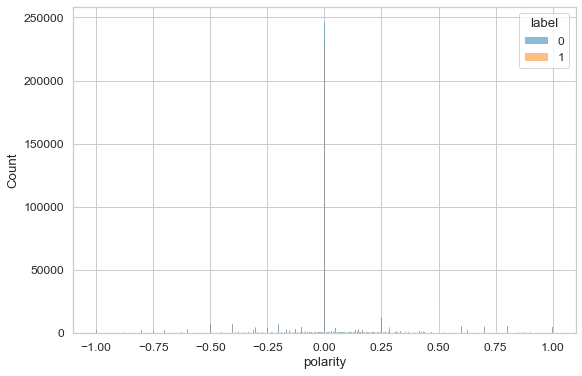

In [ ]:
plt.figure(figsize=(9,6))
sns.histplot(data=df, x='polarity', hue='label');

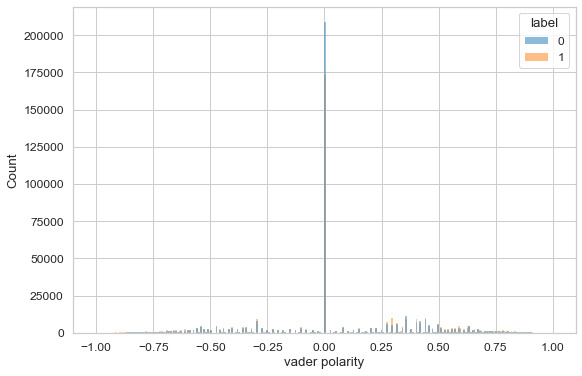

In [ ]:
plt.figure(figsize=(9,6))
sns.histplot(data=df, x='vader polarity', hue='label');

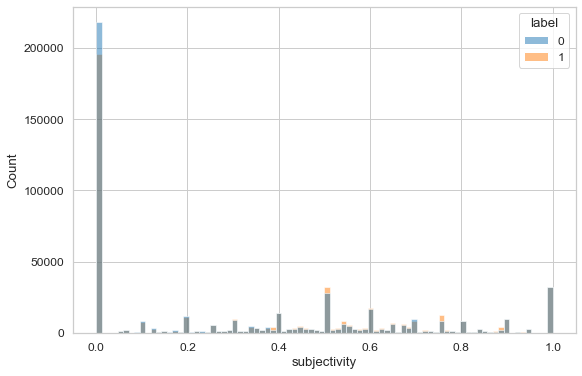

In [ ]:
plt.figure(figsize=(9,6))
sns.histplot(data=df, x='subjectivity', hue='label');

In [ ]:
def convert_to_discrete(series, a=0.6, b=0.2):
    values = series.values

    conditions = [
            (values >= -1) & (values < -a),
            (values >= -a) & (values < -b),
            (values >= -b) & (values <= b),
            (values > b) & (values <= a),
            (values > a) & (values <= 1)
    ]

    sentiments = np.arange(5)
    which = np.select(conditions, sentiments, default=np.nan).astype(int)
    
    return which

In [ ]:
df['polarity_str'] = convert_to_discrete(df['polarity'], a=0.7, b=0.05)

In [ ]:
map_sent = {0: 'extr neg', 1: 'neg', 2: 'neu', 3: 'pos', 4: 'extr pos'}
df['polarity_str'] = df['polarity_str'].map(map_sent)

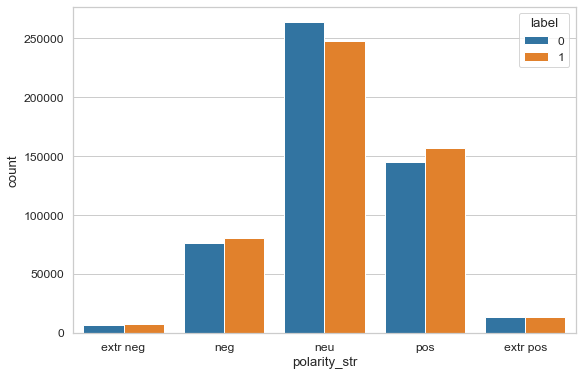

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='polarity_str', hue='label', order=map_sent.values());

In [ ]:
df['vader_polarity_str'] = convert_to_discrete(df['vader polarity'], a=0.7, b=0.05)
df['vader_polarity_str'] = df['vader_polarity_str'].map(map_sent)

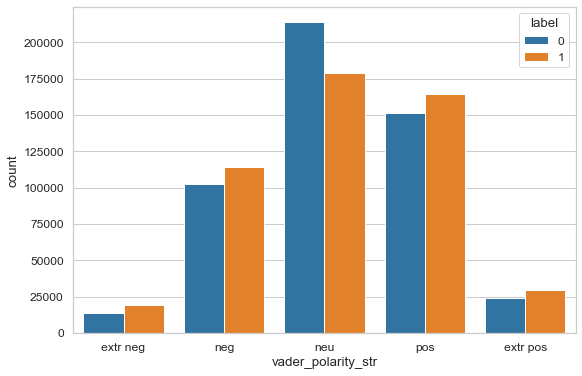

In [ ]:
plt.figure(figsize=(9,6))
sns.countplot(data=df, x='vader_polarity_str', hue='label', order=map_sent.values());

In [ ]:
df.groupby('label')['polarity'].agg(['mean', 'std'])

,mean,std
label,,
0,0.061143,0.282864
1,0.062077,0.293378


In [ ]:
df.groupby('label')['vader polarity'].agg(['mean', 'std'])

,mean,std
label,,
0,0.058109,0.370509
1,0.061520,0.402304


In [ ]:
df.groupby('label')['subjectivity'].agg(['mean', 'std'])

,mean,std
label,,
0,0.319114,0.339945
1,0.349517,0.340019


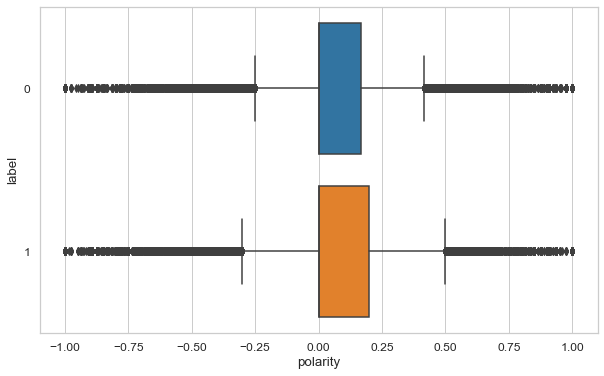

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='polarity', y='label', orient='h');

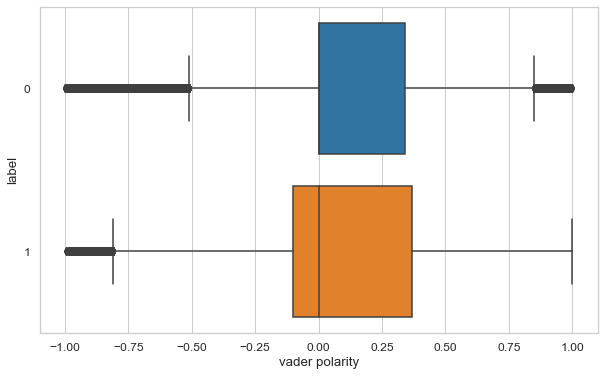

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='vader polarity', y='label', orient='h');

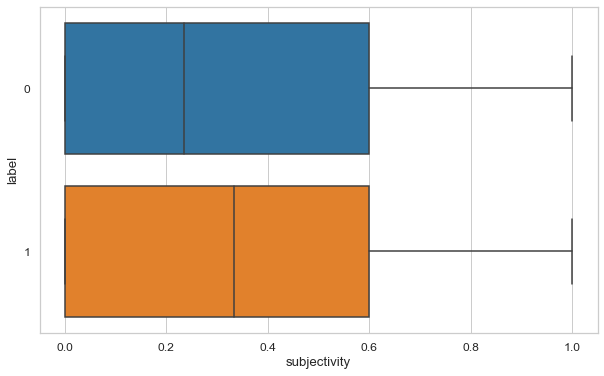

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='subjectivity', y='label', orient='h');

In [ ]:
df.drop(['polarity', 'vader polarity', 'subjectivity', 'polarity_str', 'vader_polarity_str'], axis=1, inplace=True)

In [ ]:
def preprocess(x):
    lem = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    # lemmatization, stop words and single letters
    x = " ".join([lem.lemmatize(word) for word in str(x).split() if word not in sw and len(word) > 1])
    x = re.sub(r'\s+', ' ', x).strip()  # whitespaces
    x = x if len(x) > 2 else None
    return x

df['clean comment'] = (
    df['comment']
    .str.lower() # lowercase
    .str.replace(r'[^\x00-\x7F]+', ' ', regex=True) # non-ASCII
    .str.replace(r'http\S+', '', regex=True) # links
    .str.replace(r'#\w+', '', regex=True) # hashtags
    .str.replace(r'[^\w\s\d]', ' ', regex=True) # punctuation
    .map(preprocess)
)

In [ ]:
df.head(10)

,label,comment,parent_comment,clean comment
0,0,NC and NH.,"Yeah, I get that argument. At this point, I'd ...",nc nh
1,0,You do know west teams play against west teams...,The blazers and Mavericks (The wests 5 and 6 s...,know west team play west team east team right
2,0,"They were underdogs earlier today, but since G...",They're favored to win.,underdog earlier today since gronk announcemen...
3,0,"This meme isn't funny none of the ""new york ni...",deadass don't kill my buzz,meme funny none new york nigga one
4,0,I could use one of those tools.,Yep can confirm I saw the tool they use for th...,could use one tool
5,0,"I don't pay attention to her, but as long as s...",do you find ariana grande sexy ?,pay attention long legal kick bed took load
6,0,Trick or treating in general is just weird...,What's your weird or unsettling Trick or Treat...,trick treating general weird
7,0,Blade Mastery+Masamune or GTFO!,Probably Sephiroth. I refuse to taint his grea...,blade mastery masamune gtfo
8,0,"You don't have to, you have a good build, buy ...",What to upgrade? I have $500 to spend (mainly ...,good build buy game save
9,0,I would love to see him at lolla.,Probably count Kanye out Since the rest of his...,would love see lolla


In [ ]:
df.to_csv('clean_comments.csv', index=False)

In [ ]:
raw_scores = NRCLex(df['clean comment'][df['label'] == 0].str.cat(sep=' ')).raw_emotion_scores

In [ ]:
emotions_0 = pd.DataFrame.from_dict(raw_scores, orient='index', columns=['count_0']).rename_axis('emotion').reset_index()
emotions_0['perc_0'] = (emotions_0['count_0']/emotions_0['count_0'].sum()).mul(100)

In [ ]:
emotions_0

,emotion,count_0,perc_0
0,trust,170490,12.385320
1,anticipation,140453,10.203269
2,joy,114300,8.303373
3,positive,260428,18.918905
4,anger,108112,7.853843
5,negative,216689,15.741467
6,surprise,72676,5.279580
7,disgust,76025,5.522869
8,sadness,96817,7.033313
9,fear,120559,8.758061


In [ ]:
raw_scores = NRCLex(df['clean comment'][df['label'] == 1].str.cat(sep=' ')).raw_emotion_scores

In [ ]:
emotions_1 = pd.DataFrame.from_dict(raw_scores, orient='index', columns=['count_1']).rename_axis('emotion').reset_index()
emotions_1['perc_1'] = (emotions_1['count_1']/emotions_1['count_1'].sum()).mul(100)

In [ ]:
emotions_1

,emotion,count_1,perc_1
0,fear,140051,9.311703
1,negative,243062,16.160693
2,anger,123319,8.199227
3,anticipation,144298,9.594078
4,joy,119975,7.976891
5,positive,273926,18.212777
6,trust,183506,12.200937
7,disgust,88655,5.894489
8,sadness,115115,7.653760
9,surprise,72125,4.795443


In [ ]:
df_diff = pd.merge(emotions_0, emotions_1, how='outer', on='emotion')
df_diff['diff'] = (df_diff['perc_0']-df_diff['perc_1']).abs()
df_diff = df_diff.sort_values(by='diff', ascending=False, ignore_index=True)

In [ ]:
max_perc = int(max(df_diff['perc_1'].tolist() + df_diff['perc_0'].tolist())) + 4

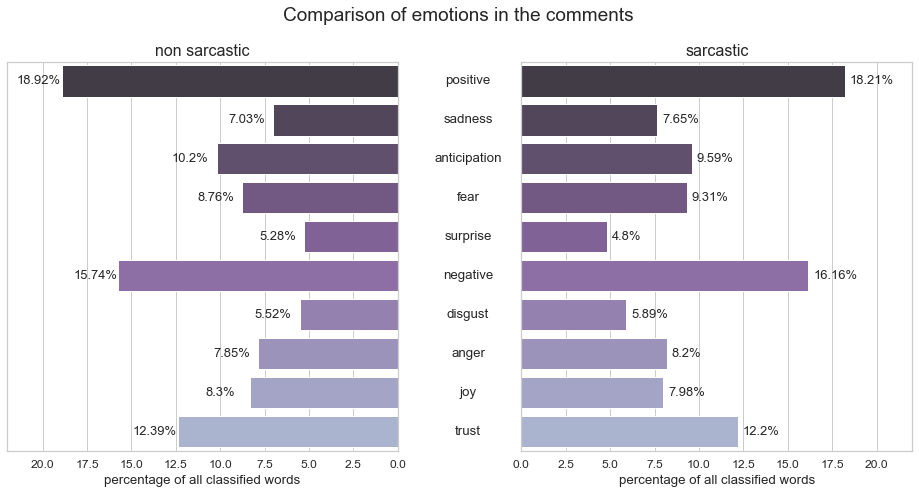

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))

sns.barplot(data=df_diff, x='perc_0', y='emotion', ax=ax1, palette='BuPu_r_d')
ax1.set_xlim([0,max_perc])
ax1.invert_xaxis()
ax1.set(yticklabels=[])
ax1.set_ylabel('')
ax1.set_xlabel('percentage of all classified words')
ax1.set_title('non sarcastic', fontsize=16)

sns.barplot(data=df_diff, x='perc_1', y='emotion', ax=ax2, palette='BuPu_r_d');
ax2.set_xlim([0,max_perc])
ax2.set_ylabel('')
ax2.set_xlabel('percentage of all classified words')
ax2.set_title('sarcastic', fontsize=16)

ax2.set(yticklabels=[])
for yloc, word in zip(np.arange(df_diff.shape[0]), df_diff.emotion):
    ax2.annotate(word, (0.5, yloc), xycoords=('figure fraction', 'data'), ha='center', va='center')
    
for ax in [ax1, ax2]:
    for c in ax.containers:
        labels = [str(round(v.get_width(), 2))+'%' for v in c]
        padding = 5 if ax == ax2 else -45
        ax.bar_label(c, labels=labels, label_type='edge', fontsize=13, padding=padding)

fig.subplots_adjust(wspace=0.4)
fig.suptitle('Comparison of emotions in the comments', fontsize=19)
plt.tight_layout()

# sentiment: comment vs parent

In [48]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [49]:
sia = SentimentIntensityAnalyzer()

def get_sentiment(comment):
    return sia.polarity_scores(comment)['compound']

sentiment_comment = df['comment'].map(get_sentiment).tolist()
sentiment_parent = df['parent_comment'].map(get_sentiment).tolist()

In [105]:
df_sent = pd.DataFrame({
    'comment_sent': sentiment_comment,
    'parent_sent': sentiment_parent,
    'label': df['label']
})

In [106]:
df_sent['abs_diff'] = np.abs(df_sent['comment_sent'] - df_sent['parent_sent'])

In [107]:
df_sent['label'] = df_sent['label'].astype(str)

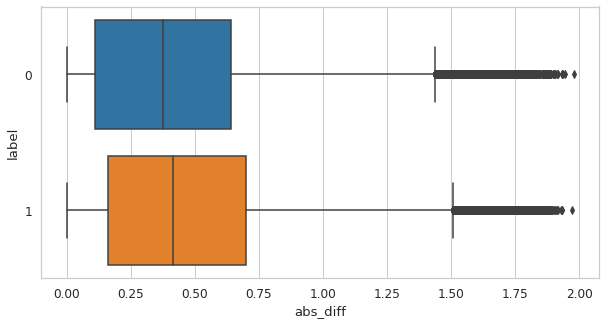

In [108]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_sent, x='abs_diff', y='label');

In [109]:
df_sent.groupby('label')['abs_diff'].mean()

label
0    0.423582
1    0.468443
Name: abs_diff, dtype: float64

In [110]:
df_sent[(df_sent['label'] == '1') & (df_sent['abs_diff'] > 1.95)]

,comment_sent,parent_sent,label,abs_diff
25047,0.9752,-0.9985,1,1.9737


In [92]:
df.iloc[25047].values

array([1,
       'lol u trihard dis is casul lol salty stoip tring 2 win look up causl in the dictionary lol calm don y r u so trihard just play 2 hav fun lol dont b so salt lol',
       'I don\'t understand this. Am I the weird one or is b4nny? I ABSOLUTELY lose my cool like this, but when I lose my cool it\'s amongst pubbers. I\'m raging at that pub Heavy that\'s too scurred to turn the next two corners into the battlefield because omg there might be enemies or he might die. I\'m raging at the frag-obsessed Soldier who can\'t figure out the point he\'s THREE FEET AWAY FROM needs to be stood on or we all lose anyways, so it\'s probably not a good time for him to rocket jump away because omg a demo, a scout and a pyro, too much let\'s bail. And most of all, I rage at the five idiots who REFUSE to push unless they\'re standing behind me as Heavy, but somehow NONE of them can manage to kill the spy that just waltzed past all of them to kill me, and their immediate reaction to my death is

In [118]:
sent_map = {-1: 'negative', 0: 'neutral', 1: 'positive'}

In [119]:
df_sent['comment_sent_dis'] = np.sign(df_sent['comment_sent']).map(sent_map)
df_sent['parent_sent_dis'] = np.sign(df_sent['parent_sent']).map(sent_map)

In [123]:
df_sent['type'] = df_sent['comment_sent_dis'] + '\n' + df_sent['parent_sent_dis']

In [150]:
order = ['negative\nnegative', 'negative\nneutral', 'negative\npositive',
         'neutral\nnegative', 'neutral\nneutral', 'neutral\npositive',
         'positive\nnegative', 'positive\nneutral', 'positive\npositive']

In [175]:
df_sent['label'] = df_sent['label'].map({'0': 'non-sarcastic', '1': 'sarcastic'})

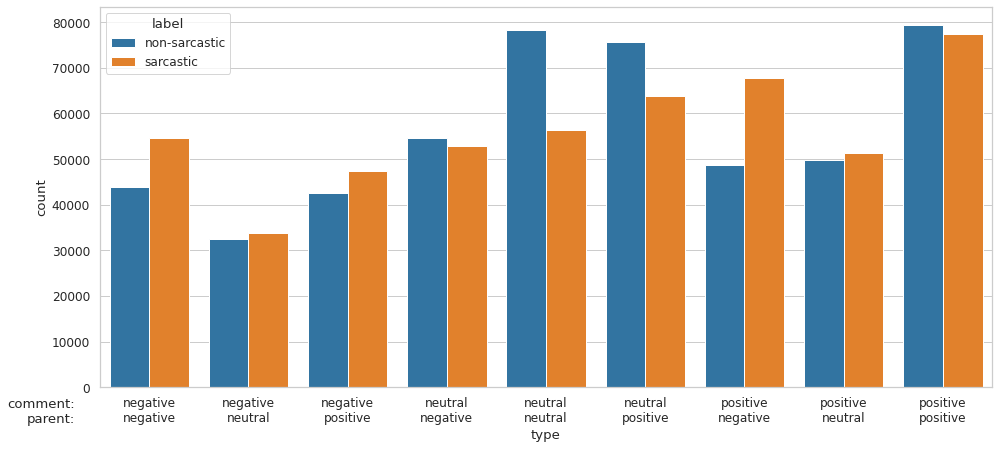

In [176]:
plt.figure(figsize=(16,7))
sns.countplot(data=df_sent, x='type', hue='label', order=order);
plt.text(-0.75, -7800, 'comment:\nparent:', ha='right');

# capitalization & punctuation count

In [101]:
def capitalization_ratio(text):
    return len(re.findall(r'[A-Z]', text)) / len(text)

In [156]:
def punctuation_ratio(text):
    return sum([1 for char in text if char in string.punctuation]) / len(text)

In [164]:
df_cap = pd.DataFrame({
    'comment': df['comment'], 'label': df['label'].astype(str),
    'cap_ratio': df['comment'].map(capitalization_ratio),
    'pun_ratio': df['comment'].map(punctuation_ratio)
})

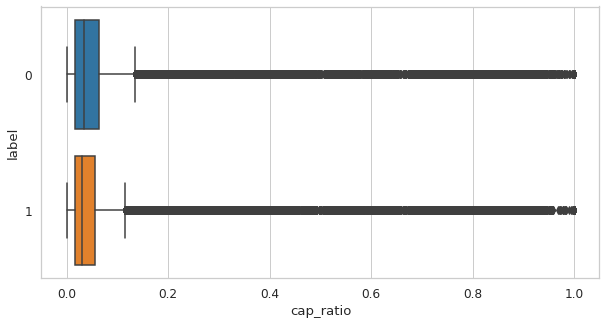

In [169]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cap, x='cap_ratio', y='label');

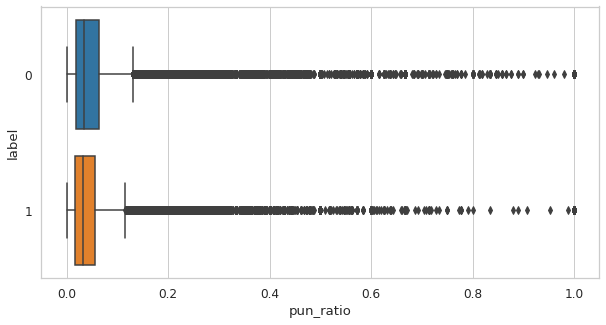

In [170]:
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_cap, x='pun_ratio', y='label');

In [172]:
df_cap.groupby('label')['cap_ratio'].mean()

label
0    0.065016
1    0.057397
Name: cap_ratio, dtype: float64

In [173]:
df_cap.groupby('label')['pun_ratio'].mean()

label
0    0.051154
1    0.042080
Name: pun_ratio, dtype: float64